In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.io import loadmat
from spectral import *
from functions import *
import rasterio
import rasterio.plot
import warnings

In [3]:
file_names = ['Airport','Beach','HYDICE_urban','San_Diego','Urban']
data_dict = {}
map_dict = {}
for file_name in file_names:
    HSI = loadmat("./dataset/{}.mat".format(file_name))
    data_dict[file_name] = HSI['data']
    map_dict[file_name] = HSI['map']


In [7]:
lev_dict = {}
rxval_dict = {}
cook_dict = {}
#dffits_dict = {}
dffits_int_dict = {}
res_int_dict = {}
#res_ext_dict = {}
lev_min_dict = {}
order = [1,1]


for file_name in file_names:
    HSI = data_dict[file_name]
    img = np.mean(HSI,axis=2)
    lev = two_dim_AR_lev(img, order)
    rxval = rx(HSI)
    cook = pixel_influence(img, order, index = 'cook_distance')
    #dffits = pixel_influence(img,order,index = 'dffits')
    dffits_int = pixel_influence(img, order, index = 'dffits_internal')
    res_int = pixel_influence(img, order, index = 'resid_studentized_internal')
    #res_ext = pixel_influence(img,order,index = 'resid_studentized_external')
    lev_min = lev_adjust(lev, order, method = 'min')

    lev_dict[file_name] = lev
    rxval_dict[file_name] = rxval / np.max(rxval)
    cook_dict[file_name] = cook
    #dffits_dict[file_name] = dffits
    dffits_int_dict[file_name] = dffits_int
    res_int_dict[file_name] = res_int
    #res_ext_dict[file_name] = res_ext
    lev_min_dict[file_name] = lev_min


In [8]:
lev_VAR_dict = {}
lev_VAR_min_dict = {}
for file_name in file_names:
    HSI = data_dict[file_name]
    lev_VAR = two_dim_VAR_lev(data_dict[file_name], order)
    lev_VAR_min = lev_adjust(lev_VAR, order, method = 'min')
    lev_VAR_dict[file_name] = lev_VAR
    lev_VAR_min_dict[file_name] = lev_VAR_min

KeyboardInterrupt: 

In [5]:
lev_3d_dict = {}
lev_3d_min_dict = {}
for file_name in file_names:
    lev_3d = three_dim_AR_lev(data_dict[file_name],order=[1,1,1],method='mean')
    lev_3d_min = lev_adjust(lev_3d, order, method = 'min')
    lev_3d_dict[file_name] = lev_3d
    lev_3d_min_dict[file_name] = lev_3d_min


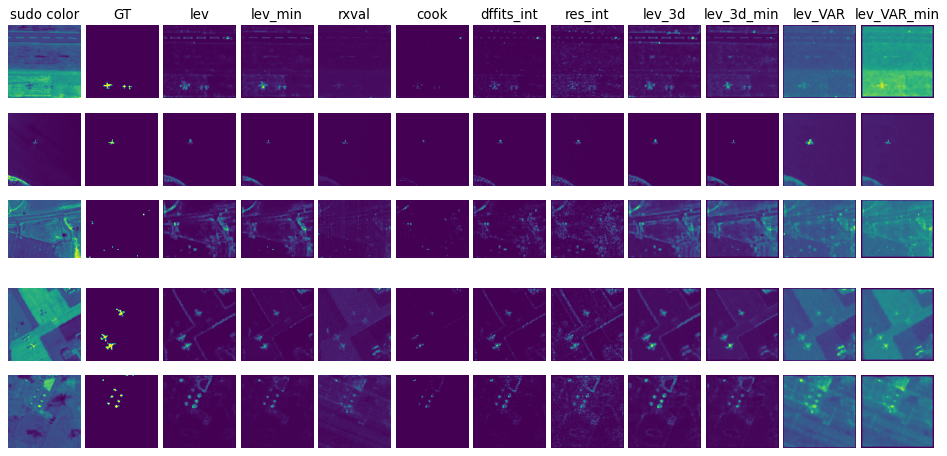

In [9]:
L = len(file_names)
approach_list = ['lev', 'lev_min', 'rxval', 'cook', 'dffits_int', 'res_int', 'lev_3d', 'lev_3d_min', 'lev_VAR', 'lev_VAR_min']
app_num = len(approach_list) + 2
fig, ax = plt.subplots(nrows=L, ncols=app_num, figsize=(15, 7), dpi=80, sharex=True, sharey=True)
i = 0
for file_name in file_names:
    j = 1
    plt.subplot(L,app_num,i*app_num + j)
    if(i==0):
        plt.title('sudo color')
    plt.imshow(np.mean(data_dict[file_name],axis=2))
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    j = j + 1

    plt.subplot(L,app_num,i*app_num + 2)
    if(i==0):
        plt.title('GT')
    plt.imshow(map_dict[file_name])
    plt.axis('off')
    plt.xticks([])
    plt.yticks([])
    j = j + 1

    for approach in approach_list:
        plt.subplot(L,app_num,i*app_num + j)
        if(i==0):
            plt.title(approach)
        exec('plt.imshow(' + approach + '_dict["' + file_name + '"])')
        plt.axis('off')
        plt.xticks([])
        plt.yticks([])
        j = j + 1
    i = i + 1
plt.subplots_adjust(wspace=0)
plt.show()

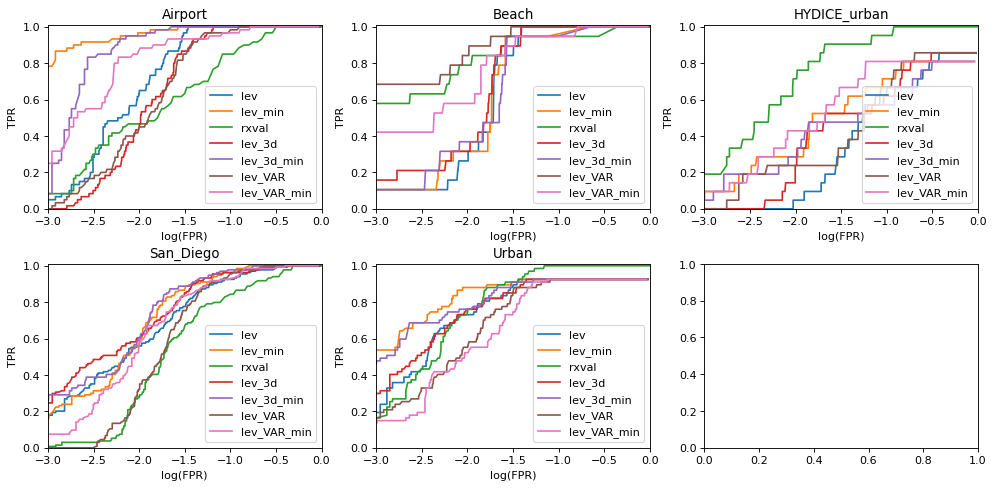

In [11]:
warnings.filterwarnings("ignore")
L = len(file_names)
approach_list = ['lev', 'lev_min', 'rxval', 'lev_3d', 'lev_3d_min', 'lev_VAR', 'lev_VAR_min']
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 7), dpi=80, sharex=False, sharey=False)
i = 1
tau_list = np.linspace(0,1,1001)
for file_name in file_names:
    plt.subplot(2,3,i)
    exec('GT = map_dict["' + file_name + '"]')
    for approach in approach_list:
        exec('anomaly_score = ' + approach + '_dict["' + file_name + '"]')
        ROC = ROC_curve(anomaly_score, GT, tau_list=tau_list)
        TPR_list = ROC['TPR_list']
        FPR_list = ROC['FPR_list']
        plt.plot(np.log10(FPR_list)[:-1],TPR_list[:-1], label = approach)
        plt.xlim([-3,0])
        plt.ylim([0,1.01])
    plt.title(file_name)
    plt.xlabel('log(FPR)')
    plt.ylabel('TPR')
    plt.legend(loc = 'lower right')
    i = i + 1
plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

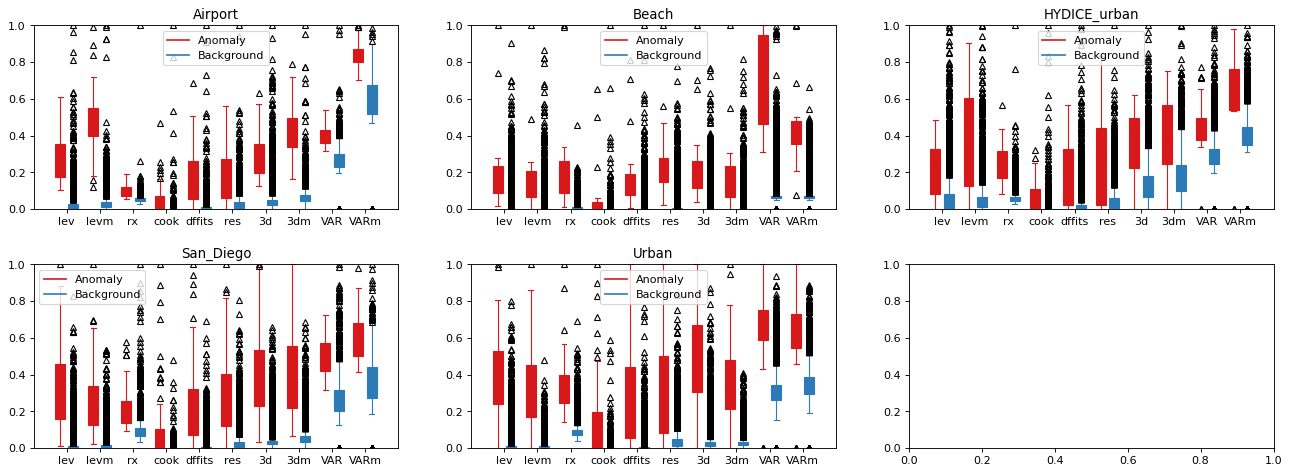

In [10]:
L = len(file_names)
approach_list = ['lev', 'lev_min', 'rxval', 'cook', 'dffits_int', 'res_int', 'lev_3d', 'lev_3d_min', 'lev_VAR', 'lev_VAR_min']
approach_names = ['lev', 'levm', 'rx', 'cook', 'dffits', 'res','3d', '3dm' , 'VAR', 'VARm']
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 7), dpi=80, sharex=False, sharey=False)
i = 1
for file_name in file_names:
    plt.subplot(2,3,i)
    anomaly_lev_list = []
    normal_lev_list = []
    exec('GT = map_dict["' + file_name + '"]')
    for approach in approach_list:
        exec('anomaly_score = ' + approach + '_dict["' + file_name + '"]')
        anomaly_lev = anomaly_score[GT == 1]
        normal_lev = anomaly_score[GT == 0]
        anomaly_lev_list.append(anomaly_lev)
        normal_lev_list.append(normal_lev)
    bpl = plt.boxplot(anomaly_lev_list, positions=np.array(range(len(anomaly_lev_list)))*2.0-0.4, sym='^', widths=0.6, patch_artist=True)
    bpr = plt.boxplot(normal_lev_list, positions=np.array(range(len(normal_lev_list)))*2.0+0.4, sym='^', widths=0.6, patch_artist=True)
    set_box_color(bpl, '#D7191C')
    set_box_color(bpr, '#2C7BB6')   

    plt.plot([], c='#D7191C', label='Anomaly')
    plt.plot([], c='#2C7BB6', label='Background')

    plt.legend()
    plt.xticks(range(0, len(approach_list) * 2, 2), approach_names)
    plt.xlim(-2, len(approach_list)*2)
    plt.ylim(0, 1)
    plt.title(file_name)
    i = i + 1

plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

        